# Single Resistor, Constant Charging Rate
About as easy as we can get for emulating a battery: $V=IR$

Let's make the voltage a linear function of the state of charge, $V(SOC) = 2 + SOC$, and assume the battery has a 1 A-hr capacity (C).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from batdata.data import BatteryDataset
import pandas as pd
import numpy as np

## Assume a Constant Current Charge
If we set $I(t) = I_0$ until fully charged and assume $SOC(0)=0$ then we can write down

$SOC(t) = I_0t/ C$

$V(t) = V(SOC(t)) + I(t) R = 2 + (t/C + R)I_0$

In [2]:
I_0 = 1  # Amp
C = 3600 # Amp-s
R = 0.1 # Ohm

Set up a 2 hour run where the first hour is charge, and the second hour is discharge

In [3]:
time = np.linspace(0, 7200, 2401)  # Every 3 seconds
time_chg, time_dhg = time[:1201], time[1201:]

Compute the segment for charge

In [4]:
current_chg = np.zeros_like(time_chg) + I_0
voltage_chg = 2 + (time_chg / C + R) * I_0

Compute the discharge.
- $I(t) = -I_0$
- $SOC(t) = 1 - I_0t/C$,
- $V(t) = V(SOC(t)) + I(t) R = 3 - (t/C + R)I_0$

In [5]:
time_during_dhg = time_dhg - 3600
current_dhg = np.zeros_like(time_dhg) - I_0
voltage_dhg = 3 - (time_during_dhg / C + R) * I_0

Combine together

In [6]:
current = -np.concatenate((current_chg, current_dhg))  # Batdata uses postive voltage for discharge, opposite of my derivation above
voltage = np.concatenate((voltage_chg, voltage_dhg))

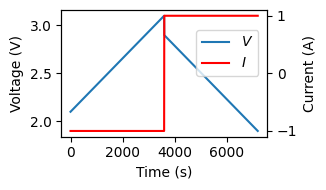

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(time, voltage, label='$V$')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

ax2 = ax.twinx()
ax2.plot(time, current, color='red', label='$I$')
ax2.set_ylabel('Current (A)')

fig.legend(loc=(0.6, 0.6))
fig.tight_layout()

## Save in HDF5 Format
So we can load it in easily later

In [8]:
raw_data = pd.DataFrame({
    'test_time': time,
    'current': current,
    'voltage': voltage,
    'cycle_number': np.zeros_like(time, dtype=int),
})

In [9]:
data = BatteryDataset(raw_data=raw_data)
data.validate()

[]

In [10]:
data.to_batdata_hdf('single-resistor-constant-charge_from-discharged.hdf', complevel=9)

## Repeat for a Version which Starts from Charged
Same thing, but reversed

In [11]:
voltage_flipped = np.concatenate(
    (voltage_dhg, voltage_chg)
)

In [12]:
raw_data = pd.DataFrame({
    'test_time': time,
    'current': np.flip(current),
    'voltage': voltage_flipped,
    'cycle_number': np.zeros_like(time, dtype=int),
})

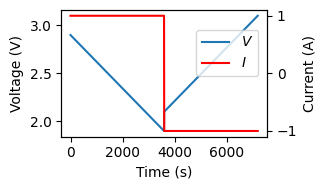

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.plot(raw_data['test_time'], raw_data['voltage'], label='$V$')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

ax2 = ax.twinx()
ax2.plot(raw_data['test_time'], raw_data['current'], color='red', label='$I$')
ax2.set_ylabel('Current (A)')

fig.legend(loc=(0.6, 0.6))
fig.tight_layout()

In [14]:
data = BatteryDataset(raw_data=raw_data)
data.validate()

[]

In [15]:
data.to_batdata_hdf('single-resistor-constant-charge_from-charged.hdf', complevel=9)